Introduction:

Bank executives don't want to hire too many teller because of the online options that a lot of customers use currently, and having just few teller can cause customers to wait in line for so long, which cause customer dissatisfaction especially senior citizens and customers that use cash transaction in their daily life. This simulation program is to help bank executives to determine the best number of tellers they need to hire.
This study excludes the clients that need to open accounts, apply for mortgages, etc, but it including only clients with routine transactions such as deposit, withdrawal, ec
c

Our Variables:
riables:
cInter-Arrble teller
Entities: Clients
ctivity Timne
Resourllers Tellers

In [110]:
#Import required libraries:
import simpy
import random
import numpy as np
from modsim import *
from random import seed, expovariate

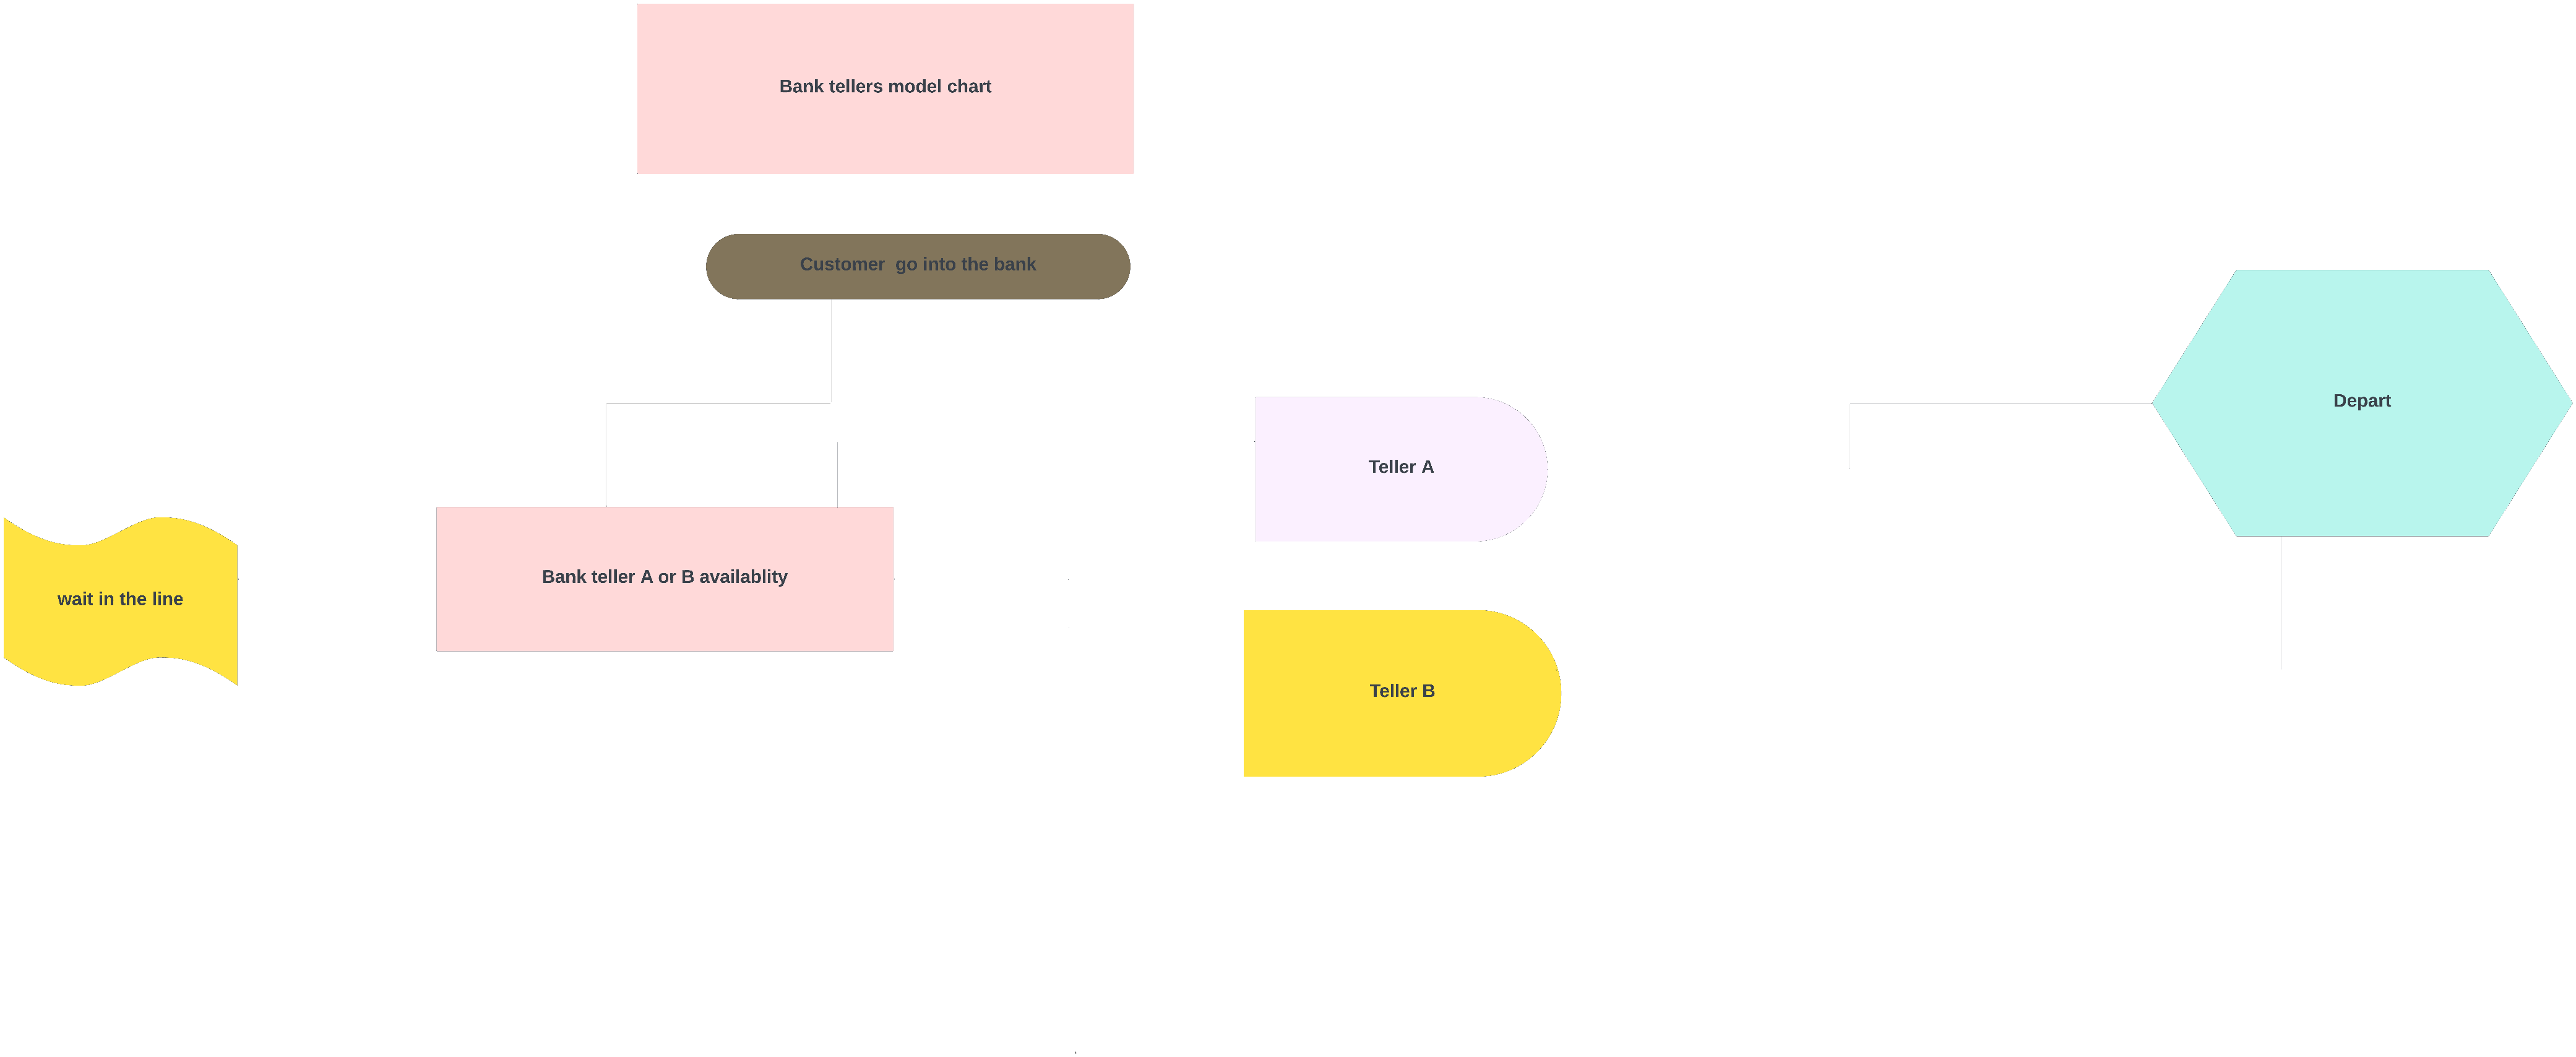

In [111]:
from IPython.display import Image
Image(filename = "C:/Users/Chafiaa/Downloads/Flowchart.png", width=600, height=700) # the char t I created

In [112]:
# Store activity times:

frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                           'time_serve','time_in_queue','time_finished_at'])

# Inter new clients into the model

def client_generator(env, mean_inter_arrival_time, mean_serve_time, teller):
    
    """ env = simulation environment 
        mean_inter_arrival_time =  mean inter-arrival time for clients coming in
        mean_serve_time =  mean time clients spend with a teller
        teller =  teller resource """
    
# client id
    
    c_id = 0
    
    while True:
        
# client activity 
        wp = activity_generator(env, mean_serve_time, teller, c_id)
        
        env.process(wp)
        
# Calculate the time until next cient arrives using randomly exponential distribution
        t = random.expovariate(1.0 / mean_inter_arrival_time)
        
# Freeze this function until inter-arrival time has elapsed
        yield env.timeout(t)
        
 # Increment the client id after inter-arrival time has elapsed
        c_id += 1

def activity_generator(env, mean_serve_time, teller, c_id):
        
    """ env = simulation environment 
        mean_serve_time =  mean time clients spend with a teller
        teller =  teller resource 
        c_id = client id """
    
# current simulation time when a client start to queue
    time_entered_queue_for_client = env.now
    frame.at[c_id, 'client_id'] = c_id
    frame.at[c_id, 'time_entered_queue'] = time_entered_queue_for_client
    
    with teller.request() as req:
        
# Call a yield until a teller is available
        
        yield req
        
        
        time_left_queue_for_client = env.now
        frame.at[c_id, 'time_left_queue'] = time_left_queue_for_client
    
        
 # Calcualte the time clients spend in waiting line
        
        time_in_queue_for_client = (time_left_queue_for_client - time_entered_queue_for_client)
        frame.at[c_id, 'time_in_queue'] = time_in_queue_for_client
    
        
 # Calculate the time clients spend with a teller using randomly exponential distribution
        sampled_serve_time = random.expovariate(1.0 / mean_serve_time)
        frame.at[c_id, 'time_serve'] = sampled_serve_time
        
# Freeze this function until served time has elapsed
        
        yield env.timeout(sampled_serve_time)
        frame.at[c_id, 'time_finished_at'] = env.now
    

def run_simulation(capacity, arrival_time, serve_time):
    
# Setup a simpy environment
    
    env = simpy.Environment()
    

# Capacity here is the number teller available.
    teller = simpy.Resource(env, capacity=capacity)

    mean_inter_arrival_time = arrival_time
    mean_serve_time = serve_time

# Set a random seed
    seed(1234) # This seed has importand role on the results

    
    env.process(client_generator(env, mean_inter_arrival_time, mean_serve_time, teller))

# Set the simulation to run for 360 minutes (6 hours bank operations)
    env.run(until=360)
    
# Calculate the idle time of no customers to serve until next customer arrival
    for c_id in range(len(frame)):
        if frame.at[c_id,'client_id'] == 0:
            frame.at[c_id, 'time_idle'] = 0
        
        elif frame.at[c_id, 'time_entered_queue'] - frame.at[c_id-1, 'time_finished_at'] < 0:
            frame.at[c_id, 'time_idle'] = 0
    
        else:
            frame.at[c_id, 'time_idle'] = frame.at[c_id, 'time_entered_queue'] - frame.at[c_id-1, 'time_finished_at']
 
    return frame
        

In [113]:
run_simulation(2, 2.5, 3).head(6)


,client_id,time_idle,time_entered_queue,time_left_queue,time_serve,time_in_queue,time_finished_at
0,0.0,0.000000,0.000000,0.000000,1.743383,0.0,1.743383
1,1.0,6.743677,8.487060,8.487060,7.256547,0.0,15.743606
2,2.0,0.000000,8.505859,8.505859,2.618455,0.0,11.124314
3,3.0,4.384797,15.509111,15.509111,0.263014,0.0,15.772126
4,4.0,2.520515,18.292640,18.292640,0.810744,0.0,19.103384
5,5.0,2.825485,21.928869,21.928869,4.664462,0.0,26.593331


The df above shows the top 6 rows result of the simulation with parameter values of 2 (capacity), 2.5 (mean inter-arrival time), and 3 (serving time, ideal serving time in the banks policy).We can see how the time elapsed from a client started queuing in the waiting line, served by a teller, to leaving the bank. For example, the client 0 arrived at the bank without queuing and went straight to the counter and left bank at 1.743383 minutes. Then all tellers have been idled for 6.743677 minutes until the second client (id=1) arrived at the bank at 8.487060 minutes.

s.

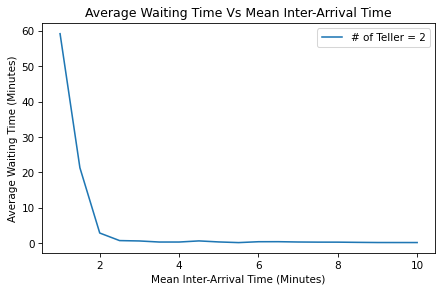

In [114]:
# Plot to show average waiting time vs inter-arrival times

from matplotlib.pyplot import *


mean_inter_arrival_array = linrange(1,10,0.5)
avg_wait_time = SweepSeries()

for inter_arrival in mean_inter_arrival_array:
    
    # Create a timeframe to store activity times
    frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                'time_serve','time_in_queue','time_finished_at'])
    
    avg_wait_time[inter_arrival] = run_simulation(2, inter_arrival, 3)['time_in_queue'].mean()

plot(avg_wait_time, label='# of Teller = ' + str(2))

decorate(xlabel='Mean Inter-Arrival Time (Minutes)',
         ylabel='Average Waiting Time (Minutes)',
         title = 'Average Waiting Time Vs Mean Inter-Arrival Time')

The average waiting time with variation of mean inter-arrival time with 2 tellers and mean serving time of 3 minutes. The average waiting time dropped sharply when the gap of client arrival time is at 1.5 minute and continue to have lower average waiting time for higher mean inter-arrival time.


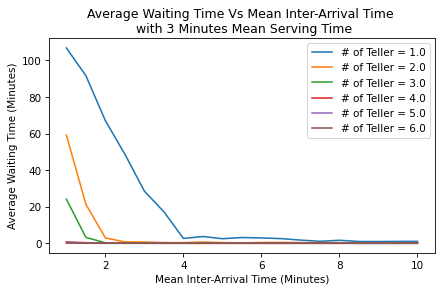

In [115]:
# Plot to show average waiting time vs mean inter-arrival with a range of capacity (# of tellers)
mean_inter_arrival_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
avg_wait_time = SweepSeries()

for capacity in capacity_array:
    for inter_arrival in mean_inter_arrival_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                   'time_serve','time_in_queue','time_finished_at'])
        
        avg_wait_time[inter_arrival] = run_simulation(capacity, inter_arrival, 3)['time_in_queue'].mean()
    
    label = '# of Teller = ' + str(capacity)
    plot(avg_wait_time, label=label)

decorate(xlabel='Mean Inter-Arrival Time (Minutes)',
         ylabel='Average Waiting Time (Minutes)',
         title = 'Average Waiting Time Vs Mean Inter-Arrival Time \n with 3 Minutes Mean Serving Time')

The average waiting time decreased as the inter-arrival time increased. This makes sense since the bigger the gap between clients arrived, tellers will have more times to handle transactions and less number clients queue at the waiting line. Also, we can see from the plot that 2 tellers or higher has average waiting time close to zero for mean inter-arrival time 1.5 minutes or higher.


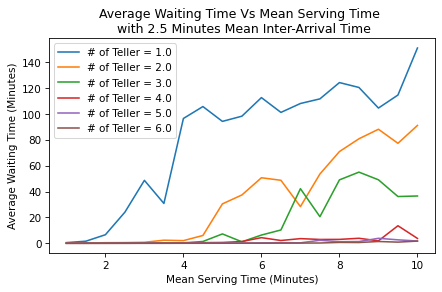

In [116]:
mean_serve_time_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
avg_wait_time = SweepSeries()

for capacity in capacity_array:
    for serve_time in mean_serve_time_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                   'time_serve','time_in_queue','time_finished_at'])
        
        avg_wait_time[serve_time] = run_simulation(capacity, 2.5, serve_time)['time_in_queue'].mean()
    
    label = '# of Teller = ' + str(capacity)
    plot(avg_wait_time, label=label)

decorate(xlabel='Mean Serving Time (Minutes)',
         ylabel='Average Waiting Time (Minutes)',
         title = 'Average Waiting Time Vs Mean Serving Time \n with 2.5 Minutes Mean Inter-Arrival Time')

The average waiting time increased as the mean serving time increased. The longer it takes for a teller to handle transactions, there are less tellers available for the coming clients and higher waiting time for clients in the queue line. It's interesting to see that the trends of average waiting time for 4 tellers or higher has not been affected by longer serving time. It's close to zero average waiting time.


AttributeError: Axes.set() got an unexpected keyword argument 'loc'

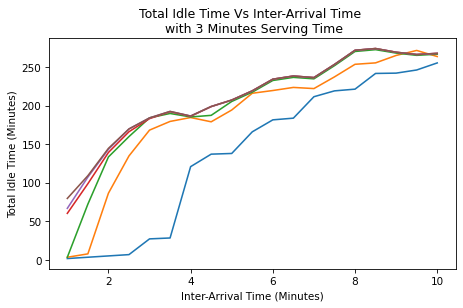

In [117]:
# Plot to show total idle time versus inter-arrival time
mean_inter_arrival_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
total_idle_time = SweepSeries()

plt.figure(figsize=(7, 4))

for capacity in capacity_array:
    for inter_arrival in mean_inter_arrival_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                            'time_serve','time_in_queue','time_finished_at'])
        
        total_idle_time[inter_arrival] = run_simulation(capacity, inter_arrival, 3)['time_idle'].sum()
    label = '# of Teller = ' + str(capacity)
    plot(total_idle_time, label=label)

decorate(xlabel='Inter-Arrival Time (Minutes)',
         ylabel='Total Idle Time (Minutes)',
         title = 'Total Idle Time Vs Inter-Arrival Time \n with 3 Minutes Serving Time',
         loc = 'upper left')

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.tight_layout()

As more tellers are available to serve clients, the total idle time is also increased. 3 tellers or higher shows the same trend. When there is only one teller, it has significant less idle time compared to 2 or more tellers in place. 


AttributeError: Axes.set() got an unexpected keyword argument 'loc'

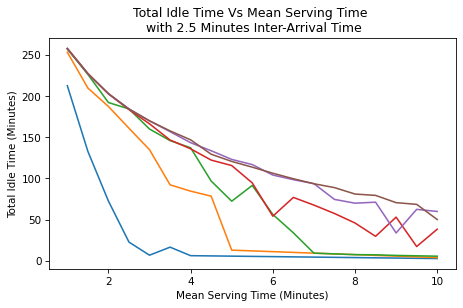

In [118]:
# Plot to show total idle time versus mean serving time
mean_serve_time_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
total_idle_time = SweepSeries()

plt.figure(figsize=(7, 4))

for capacity in capacity_array:
    for serve_time in mean_serve_time_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                   'time_serve','time_in_queue','time_finished_at'])
        
        total_idle_time[serve_time] = run_simulation(capacity, 2.5, serve_time)['time_idle'].sum()
    
    label = '# of Teller = ' + str(capacity)
    plot(total_idle_time, label=label)

decorate(xlabel='Mean Serving Time (Minutes)',
         ylabel='Total Idle Time (Minutes)',
         title = 'Total Idle Time Vs Mean Serving Time \n with 2.5 Minutes Inter-Arrival Time',
         loc = 'upper left')

plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

The total idle time started to decrease as the mean serving time increased. This makes a lot of sense because the longer it takes for tellers to handling transactions, they will have less idle time. The total idle time reached close to zero at 4.5 minutes mean serving time when only one teller in place.
.

AttributeError: Axes.set() got an unexpected keyword argument 'loc'

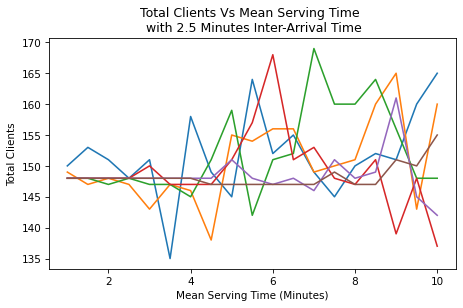

In [119]:
# Plot to show total number of clients versus mean serving time
mean_serve_time_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
total_clients = SweepSeries()

plt.figure(figsize=(7, 4))

for capacity in capacity_array:
    for serve_time in mean_serve_time_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                   'time_serve','time_in_queue','time_finished_at'])
        
        total_clients[serve_time] = len(run_simulation(capacity, 2.5, serve_time)['client_id'])
    
    label = '# of Teller = ' + str(capacity)
    plot(total_clients, label=label)

decorate(xlabel='Mean Serving Time (Minutes)',
         ylabel='Total Clients',
         title = 'Total Clients Vs Mean Serving Time \n with 2.5 Minutes Inter-Arrival Time',
         loc = 'upper left')

plt.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

The higher the mean inter-arrival time, the less clients tellers will serve per working day. This indicates that higher mean serving time may not necessary impact the average waiting time if inter-arrival time between clients is high enough. The total number of clients that tellers can serve per working day varies also for different mean serving time and number of tellers.



s.

AttributeError: Axes.set() got an unexpected keyword argument 'loc'

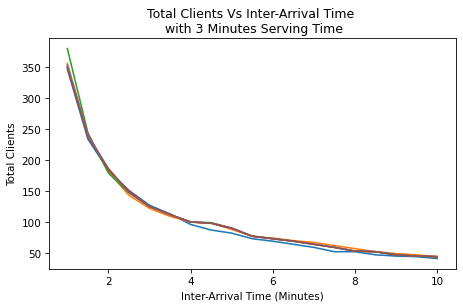

In [120]:
# Plot to show total number of clients versus mean inter-arrival time
mean_inter_arrival_array = linrange(1,10,0.5)
capacity_array = linrange(1,6)
total_clients = SweepSeries()

plt.figure(figsize=(7, 4))

for capacity in capacity_array:
    for inter_arrival in mean_inter_arrival_array:
        
        # Create a timeframe to store activity times
        frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                            'time_serve','time_in_queue','time_finished_at'])
        
        total_clients[inter_arrival] = len(run_simulation(capacity, inter_arrival, 3)['client_id'])
    label = '# of Teller = ' + str(capacity)
    plot(total_clients, label=label)

decorate(xlabel='Inter-Arrival Time (Minutes)',
         ylabel='Total Clients',
         title = 'Total Clients Vs Inter-Arrival Time \n with 3 Minutes Serving Time',
         loc = 'upper left')

plt.legend(bbox_to_anchor=(1.00, 1.02))
plt.tight_layout()

We can clearly see that 2 tellers is the optimal number of tellers to hire. 1 teller definitely is not enough to handle day to day transactions. 1 teller will require much higher mean inter-arrival time (~ 9 minutes) and much lower mean serving time. 3 tellers or more will be a waste as idling time.




In [121]:
frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                'time_serve','time_in_queue','time_finished_at'])
print("Average waiting time is ", run_simulation(2, 2.5, 3)['time_in_queue'].mean(), " minutes")

Average waiting time is  0.7719063893077491  minutes


In [122]:
frame = TimeFrame(columns=['client_id','time_idle','time_entered_queue','time_left_queue',
                                'time_serve','time_in_queue','time_finished_at'])
print("Total idle time is ", run_simulation(2, 2.5, 3)['time_idle'].sum(), " minutes")

Total idle time is  134.75750651324762  minutes


In [123]:
count_3min = run_simulation(2, 2.5, 3).apply(lambda x : True if x['time_in_queue'] < 3 else False, axis = 1)
pct_3min = round(np.sum(count_3min)/len(count_3min)*100, 2)

print("The percentage of clients whose waiting time is 3 minutes or less is ", pct_3min, "%")

The percentage of clients whose waiting time is 3 minutes or less is  90.21 %


Conclusions:
This bank teller simulation showed great results, it has demonstrated that bank executives can use this simulation to figure out the optimal number of tellers based on the mean inter-arrival time and the mean serving time for a client. To decide the number of tellers to hire, the bank executives can use reasonable parameters based on bank location and the number of clients coming in every working day looking for tellers, example in big city the bank will definitely need then 2 tellers.

